# Getting needed files

In [1]:
# note: possibly, if the notebook isn't shared with others and you press "Mount Drive", then you might not have to remount it each time.

from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/vars.pkl vars.pkl
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/seas_mask.npy seas_mask.npy

# drive.flush_and_unmount()

Mounted at /content/drive


variable_list ('concentration', 'extent', 'land', 'msl', 'q_500hPa', 'slhf', 'sp', 'sshf', 'ssr', 'ssrd', 'sst', 't2m', 't_500hPa', 'tp', 'u10', 'u_10hPa', 'v10', 'z_250hPa', 'z_500hPa', 'cos_month', 'sin_month')
mask 19.34%


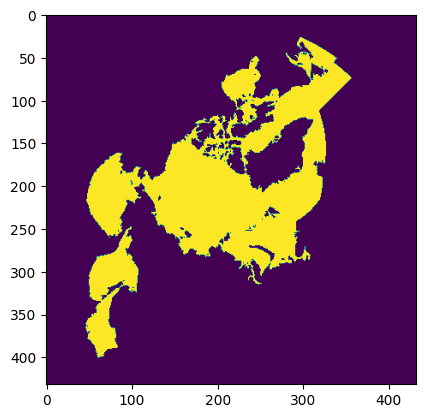

In [2]:
import numpy as np
import pickle
from matplotlib import pyplot as plt

with open('vars.pkl', 'rb') as f:
  variable_list = pickle.load(f)

# mask for the 9 Arctic seas, so that only values within these are counted when creating metrics.
# this is of the shape (x, y, 1). the final dimension may be a bit annoying
seas_mask = np.load('seas_mask.npy') * 1.0

print(f"variable_list {variable_list}")
print(f"mask {100 * np.sum(seas_mask) / np.size(seas_mask):.2f}%")
plt.imshow(seas_mask);

#Code needed to load results
Copied directly from model notebook. DO NOT MODIFIY here. Modify in model notebook and copy here again for consistency.

In [3]:
# allow loading models to work
!pip install --upgrade tensorflow==2.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling te

In [4]:
# Code in this cell is shared between model and view results. Make sure to keep them consistent!!!

import tensorflow as tf
from tensorflow import keras

# not used right now, but kept in case we might use it
# why is there a minus sign at the start?
def wavelet_activation(x):
  return -x * tf.exp(-x**2)

# ignore land when calculating loss

# note that land is normalized and was originally 0 for no land and 1 for land, so land is positive and non-land is negative
# note that the last dimension of this is 1, so multiplying this with things with greater last dimensions works.
# not needed, since not using this as a mask but instead the seas
#non_land_mask = (get_X_with_variables(('land',))[0] < 0)

def masked_mse(y_true, y_pred):
  y_true_masked = tf.math.multiply(y_true, seas_mask)
  y_pred_masked = tf.math.multiply(y_pred, seas_mask)
  # scale the result to act like you only count the values in seas_mask
  # the division by the last element of the shape is since y_true may have multiple variables while seas_mask may have less
  return keras.losses.mean_squared_error(y_true_masked, y_pred_masked) * tf.cast(tf.size(y_true) / tf.shape(y_true)[-1], tf.float32) / tf.reduce_sum(seas_mask.astype(np.float32))

# binary crossentropy
def masked_bce(y_true, y_pred):
  y_true_masked = tf.math.multiply(y_true, seas_mask)
  y_pred_masked = tf.math.multiply(y_pred, seas_mask)
  # take the mean crossentropy over the mask
  # note that values predicted right have zero loss so you can ignore values outside the mask
  return tf.math.reduce_sum(keras.losses.binary_crossentropy(y_true_masked, y_pred_masked)) / tf.reduce_sum(seas_mask.astype(np.float32))

In [5]:
# Code in this cell is shared between model and view results. Make sure to keep them consistent!!!

import numpy as np
import os
import pickle
import shutil

from pathlib import Path
from tensorflow import keras
from typing import Dict, List, Union, Tuple

RESULTS_PATH = 'drive/MyDrive/Andrew Arctic ice research/Results'

class GoogleDriveContextManager:
  def __init__(self):
    self.mounted = False

  def __enter__(self):
    path = '/content/drive'
    if not os.path.exists(path):
      drive.mount('/content/drive')
      self.mounted = True

  def __exit__(self, exc_type, exc_value, exc_tb):
    # Only unmount if context manager mounted it
    if self.mounted:
      drive.flush_and_unmount()
      self.mounted = False

class Result:
  # note that history isn't a keras.callbacks.History but rather the .history of it
  def __init__(self,
               model:Union[keras.Model, List[keras.Model]],
               history: Union[Dict[str, Tuple[float, ...]], List[dict[str, tuple[float, ...]]]],
               train_y_actual: np.ndarray,
               train_y_hat: np.ndarray,
               val_y_actual: np.ndarray,
               val_y_hat: np.ndarray,
               test_y_actual: np.ndarray,
               test_y_hat: np.ndarray,
               ) -> None:
    self.model = model
    self.history = history
    self.train_y_actual = train_y_actual
    self.train_y_hat = train_y_hat
    self.val_y_actual = val_y_actual
    self.val_y_hat = val_y_hat
    self.test_y_actual = test_y_actual
    self.test_y_hat = test_y_hat

  @staticmethod
  def _to_model_filename(i: int) -> str:
    return "model.keras" if i ==0 else f"model_{i}.keras"

  # saving val_y_actual and test_y_actual is technically redundant but slightly more convenient,
  # though maybe it should be standardized as the lead time may change which points are included
  # note that this doesn't have results; those should be calculated based on what is saved here.
  def save_to(self,
              folder: os.PathLike,
              to_gdrive: bool = True,
              force: bool = False,
              ) -> None:
    if os.path.exists(folder):
      shutil.rmtree(folder)

    Path(folder).mkdir(parents=True)

    if isinstance(self.model, keras.Model):
      models = [self.model]
    else:
      models = self.model
    for i, model in enumerate(models):
      model.save(os.path.join(folder, self._to_model_filename(i)))

    with open(os.path.join(folder, 'results.pkl'), 'wb') as f:
      pickle.dump({'history': self.history,
                   'train_y_actual': self.train_y_actual,
                   'train_y_hat': self.train_y_hat,
                   'val_y_actual': self.val_y_actual,
                   'val_y_hat': self.val_y_hat,
                   'test_y_actual': self.test_y_actual,
                   'test_y_hat': self.test_y_hat,
                   },
                  f)

    if to_gdrive:
      with GoogleDriveContextManager():
        dst = os.path.join(RESULTS_PATH, folder)
        if force:
          shutil.rmtree(dst, ignore_errors=True)
        Path(dst).mkdir(parents=True)
        shutil.copytree(folder, dst, dirs_exist_ok=True)

  @classmethod
  def from_gdrive(cls, folder: os.PathLike):# -> Result:
    with GoogleDriveContextManager():
      shutil.rmtree(folder, ignore_errors=True)
      Path(folder).mkdir(parents=True)
      shutil.copytree(os.path.join(RESULTS_PATH, folder), folder, dirs_exist_ok=True)

    files = os.listdir(folder)
    model_files = [f for f in files if f.endswith(".keras")]
    n_model = len(model_files)
    models = []
    for i in range(n_model):
      model = keras.models.load_model(
        os.path.join(folder, Result._to_model_filename(i)),
        custom_objects={
          'masked_mse': masked_mse,
          'masked_bce': masked_bce,
          'wavelet_activation': wavelet_activation,
        }
      )
      models.append(model)
    # unbox if only one model
    if n_model == 1:
      models = models[0]

    with open(os.path.join(folder, 'results.pkl'), 'rb') as f:
      results = pickle.load(f)

    return cls(models, results['history'], results['train_y_actual'], results['train_y_hat'], results['val_y_actual'], results['val_y_hat'], results['test_y_actual'], results['test_y_hat'])

# Code needed to view results

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, log_loss, confusion_matrix, roc_auc_score
from math import sqrt

def expand_mask(shape, mask=seas_mask):
  assert len(shape) == 4
  assert mask.shape[1] == shape[1] == shape[2]
  return np.tile(np.expand_dims(mask, 0), (shape[0], 1, 1, shape[3]))

def masked(array, mask=seas_mask):
  return array * expand_mask(array.shape, )

def flatten_and_mask(array, mask=seas_mask):
  expanded_mask = expand_mask(array.shape, mask)
  return array.flatten()[expanded_mask.flatten().astype(bool)]

def is_classification(array):
  return len(np.unique(array)) == 2

def metrics(actual, predicted, mask=seas_mask):
  actual = flatten_and_mask(actual, mask)
  predicted = flatten_and_mask(predicted, mask)
  classification = is_classification(actual)
  assert classification == is_classification(predicted)

  mse = mean_squared_error(actual, predicted)
  results = {
    'mse': mse,
    'rmse': sqrt(mse),
    'mae': mean_absolute_error(actual, predicted),
    'r2': r2_score(actual, predicted)
  }
  if classification:
    results['bin_acc'] = accuracy_score(actual, predicted)
    results['log_loss'] = log_loss(actual, predicted)
    results['auc'] = roc_auc_score(actual, predicted)
    results['confusion'] = confusion_matrix(actual, predicted, normalize="true")
  else:
    results['bin_acc'] = np.nan
    results['log_loss'] = np.nan
    results['auc'] = np.nan
    results['confusion'] = [[np.nan, np.nan], [np.nan, np.nan]]
  return results


In [7]:
import pandas as pd
start_year = 1988
end_year = 2022

start_date = f'{start_year}-01-01'
end_date = f'{end_year}-12-01'

date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
# mostly modified from get_sequences()
total_size = len(date_range)
val_and_test_size = total_size // 4
test_size = total_size // 8
val_start = total_size - val_and_test_size
test_start = total_size - test_size
# cut off first 12 of each since those are only for X
# note that for 24-month input data, this is 12 months off, but this doesn't matter if just looking at the actual month
train_dates = date_range[:val_start][12:]
val_dates = date_range[val_start:test_start][12:]
test_dates = date_range[test_start:][12:]

In [8]:
from typing import Tuple, List

RESULTS_PATH = 'drive/MyDrive/Andrew Arctic ice research/Results'

def load_experiments(snapshot: str, path: str='drive/MyDrive/Andrew Arctic ice research/Results'):
  with GoogleDriveContextManager():
    experiments = {name: Result.from_gdrive(f"{snapshot}/{name}") for name in os.listdir(f"{RESULTS_PATH}/{snapshot}")}
    print(f"Loaded {len(experiments)} experiments from {RESULTS_PATH}/{snapshot}")
    return experiments

def to_metrics_df(experiments: List[Tuple[str, Result]]) -> pd.DataFrame:
  # Summarize result into DataFrame

  metrics_list = []
  for predict_month in range(0, 13): # 0 has special meaning of all month
    for lead_month in range(0, 7): # 0 has special meaning of all month
      for name, result in experiments.items():
        metrics_dict = {}
        metrics_dict["exp"] = name
        metrics_dict["predict_month"] = predict_month
        metrics_dict["lead_month"] = lead_month

        # y has dimenion (predict_month, x, y, lead_month)
        shape = result.val_y_actual.shape
        month_offset = val_dates[0].month
        predict_month_indices = [i for i in range(shape[0]) if (i + month_offset) % 12 == predict_month % 12] if predict_month > 0 else list(range(shape[0]))
        lead_month_indices = [i for i in range(shape[3]) if i + 1 == lead_month] if lead_month > 0 else list(range(shape[3]))
        val_actual = result.val_y_actual[predict_month_indices, :, :, :][:, :, :, lead_month_indices]
        val_hat = result.val_y_hat[predict_month_indices, :, :, :][:, :, :, lead_month_indices]
        metrics_dict.update(metrics(val_actual, val_hat, mask=seas_mask))

        metrics_list.append(metrics_dict)

  return pd.DataFrame.from_records(data=metrics_list)

def load_metrics_df(snapshot: str, path: str='drive/MyDrive/Andrew Arctic ice research/Results'):
  experiments = load_experiments(snapshot, path)
  return to_metrics_df(experiments)

# Looking at results

In [9]:
snapshot = "final_20231106_ensemble"

## Save land mask (don't need to do if it already is there)

In [ ]:
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/X.npy X.npy

X = np.load('X.npy')

with open('vars.pkl', 'rb') as f:
  variable_list = pickle.load(f)

# get the correct dataset for a set of variables
def get_X_with_variables(variables=variable_list):
  return X[:, :, :, [v in variables for v in variable_list]]

land_mask = get_X_with_variables(('land',))[0,:,:,0] > 0
np.save('land_mask.npy', land_mask)
!cp land_mask.npy drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/land_mask.npy
drive.flush_and_unmount()

## Plotting, if there already is a land mask

In [10]:
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/land_mask.npy land_mask.npy
land_mask = np.load('land_mask.npy')

In [11]:
experiments = load_experiments(snapshot, 'drive/MyDrive/Andrew Arctic ice research/Results')

Loaded 1 experiments from drive/MyDrive/Andrew Arctic ice research/Results/final_20231106_ensemble


In [12]:
from matplotlib.colors import Normalize

In [13]:
'''
# old color scheme
# note:
# - maybe allow specifying file name
# - if show_predicted is False, then leadtime is not needed
def plot_func(date, leadtime, title=True, download=False, show_actual=True, show_predicted=True):
  date_idx = list(test_dates[12:]).index(date)
  idx = date_idx - leadtime + 1 # idx+leadtime-1==date_idx
  if show_actual:
    plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[idx,:,:,leadtime-1].transpose()/2, norm=Normalize(0, 1), cmap='Blues', interpolation='none')
  if show_predicted:
    plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[idx,:,:,leadtime-1].transpose()/2, norm=Normalize(0, 1), cmap='YlOrRd', interpolation='none')
  plt.imshow(np.ones((432, 432)), alpha=1.0*land_mask.transpose(), norm=Normalize(0, 3/2), cmap='Greys', interpolation='none')
  plt.axis('off')
  if title:
    plt.title(f"{date.strftime('%B %Y')}, {leadtime} months lead time")
  if download:
    plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
    #plt.close(fig)
'''

In [40]:
# new color scheme: orange is actual, purple is predicted
# note:
# - maybe allow specifying file name
# - if show_predicted is False, then leadtime is not needed
def plot_func(date, leadtime, title=True, download=False, show_actual=True, show_predicted=True):
  # to do: clean up
  try:
    date_idx = list(test_dates[12:]).index(date)
  except ValueError:
    print(date.strftime(f"%B %Y for {leadtime}mo lead time is not in the testing dataset; trying validation dataset"))
    try:
      date_idx = list(val_dates[12:]).index(date)
    except ValueError:
      # note: the training dataset doesn't actually work since it's not there for some reason
      print(date.strftime(f"%B %Y for {leadtime}mo lead time is not in the validation dataset; trying training dataset"))
      date_idx = list(train_dates[12:]).index(date)
      idx = date_idx - leadtime + 1 # idx+leadtime-1==date_idx
      y_actual = experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].train_y_actual[idx,:,:,leadtime-1]
      y_hat = experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].train_y_hat[idx,:,:,leadtime-1]
    else:
      idx = date_idx - leadtime + 1 # idx+leadtime-1==date_idx
      y_actual = experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].val_y_actual[idx,:,:,leadtime-1]
      y_hat = experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].val_y_hat[idx,:,:,leadtime-1]
  else:
    idx = date_idx - leadtime + 1 # idx+leadtime-1==date_idx
    y_actual = experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[idx,:,:,leadtime-1]
    y_hat = experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[idx,:,:,leadtime-1]
  plt.imshow(np.ones((432, 432)), norm=Normalize(0, 3), cmap='Blues', interpolation='none')
  if show_actual:
    plt.imshow(np.ones((432, 432)), alpha=y_actual.transpose()/2, norm=Normalize(0, 2), cmap='hot', interpolation='none')
  if show_predicted:
    plt.imshow(np.ones((432, 432)), alpha=y_hat.transpose()/2, norm=Normalize(0, 3/2), cmap='Purples', interpolation='none')
  plt.imshow(np.ones((432, 432)), alpha=1.0*land_mask.transpose(), norm=Normalize(0, 3/2), cmap='Greys', interpolation='none')
  plt.axis('off')
  if title:
    plt.title(f"{date.strftime('%B %Y')}, {leadtime} month{'s' if leadtime != 1 else ''} lead time")
  if download:
    plt.savefig(date.strftime(f"%Y-%m {leadtime}mo.png"), bbox_inches='tight', pad_inches=0)
    #plt.close(fig)

In [ ]:
# to do: clean up the cells
# also, why is the actual for 2020-09 1mo different than the other lead times?
# to do: also download images for March
# and make an image for the legend

In [31]:
val_dates

DatetimeIndex(['2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [27]:
train_dates

DatetimeIndex(['1989-01-01', '1989-02-01', '1989-03-01', '1989-04-01',
               '1989-05-01', '1989-06-01', '1989-07-01', '1989-08-01',
               '1989-09-01', '1989-10-01',
               ...
               '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01',
               '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
               '2014-02-01', '2014-03-01'],
              dtype='datetime64[ns]', length=303, freq='MS')

In [29]:
experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].val_y_actual

array([[[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0.

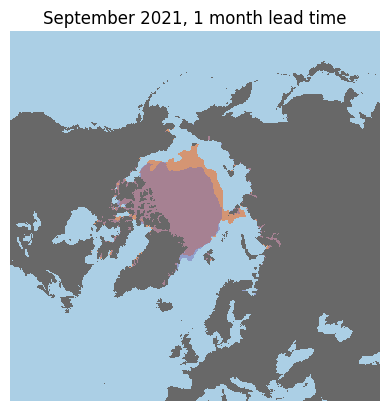

In [47]:
plot_func(pd.to_datetime('2021-09-01'), 1, download=True)

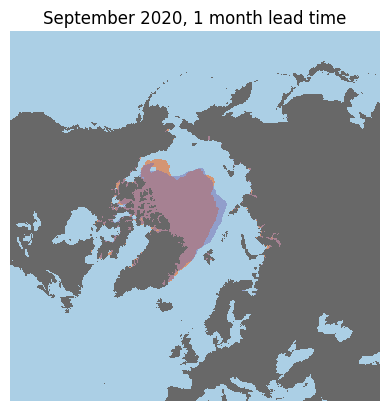

In [49]:
plot_func(pd.to_datetime('2020-09-01'), 1, download=True)

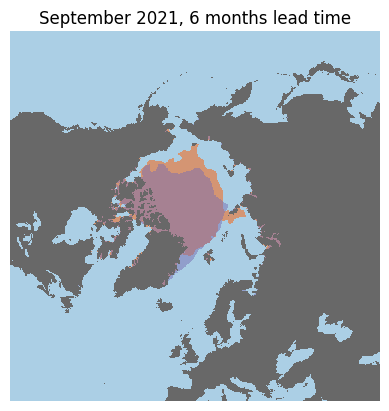

In [55]:
# 2020 and 2021 for lead times 1, 3, 6
# 2020 is the second-lowest SIE, 2021 comparatively has much more

plot_func(pd.to_datetime('2020-09-01'), 1, download=True)
plot_func(pd.to_datetime('2020-09-01'), 3, download=True)
plot_func(pd.to_datetime('2020-09-01'), 6, download=True)
plot_func(pd.to_datetime('2021-09-01'), 1, download=True)
plot_func(pd.to_datetime('2021-09-01'), 3, download=True)
plot_func(pd.to_datetime('2021-09-01'), 6, download=True)

In [ ]:
plot_func(pd.to_datetime('2021-09-01'), 1, download=True)

In [30]:
val_dates

DatetimeIndex(['2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [26]:
plot_func(pd.to_datetime('2013-09-01'), 1, download=True)

September 2013 for 1mo lead time is not in the testing dataset; trying validation dataset
September 2013 for 1mo lead time is not in the validation dataset; trying training dataset


TypeError: 'NoneType' object is not subscriptable

In [24]:
val_dates

DatetimeIndex(['2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01'],
              dtype='datetime64[ns]', freq='MS')

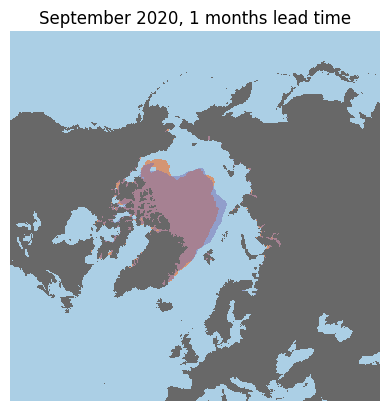

In [15]:
plot_func(pd.to_datetime('2020-09-01'), 1, download=True)

In [16]:
plot_func(pd.to_datetime('2013-09-01'), 1, download=True)

ValueError: Timestamp('2013-09-01 00:00:00') is not in list

In [ ]:
# plotted dates:
# all September
# 2012 (lowest SIE), 2020 (second-lowest SIE), 2013 (unusually high SIE)

In [ ]:
plot_func(pd.to_datetime('2020-09-01'), 1, download=True)

In [ ]:
# probably do the years listed in Andersson et al. 2021

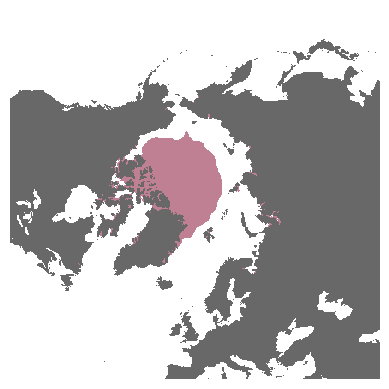

In [ ]:
# for model architecture figure
#plot_func(pd.to_datetime('2022-03-01'), 6, title=False, download=True, show_actual=True, show_predicted=False)
plot_func(pd.to_datetime('2022-09-01'), 6, title=False, download=True, show_actual=False, show_predicted=True)

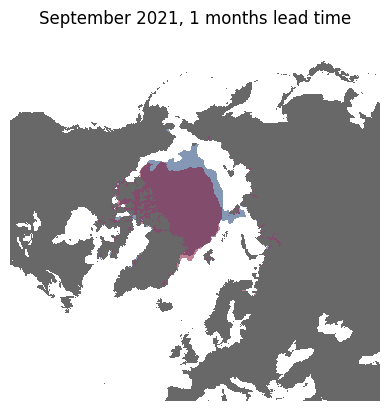

In [16]:
plot_func(pd.to_datetime('2021-09-01'), 1, download=True)

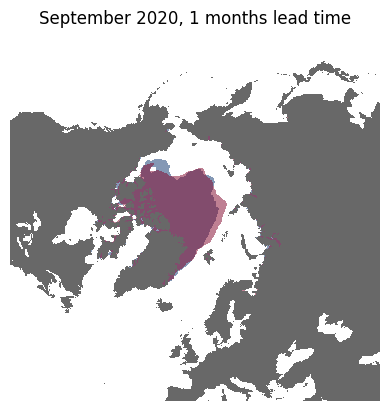

In [19]:
plot_func(pd.to_datetime('2020-09-01'), 1, download=True)

In [20]:
plot_func(pd.to_datetime('2013-09-01'), 1, download=True)

ValueError: Timestamp('2013-09-01 00:00:00') is not in list

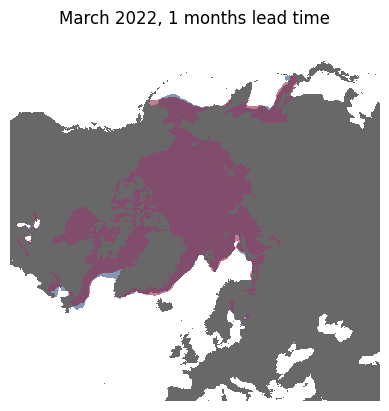

In [18]:
plot_func(pd.to_datetime('2022-03-01'), 1, download=True)

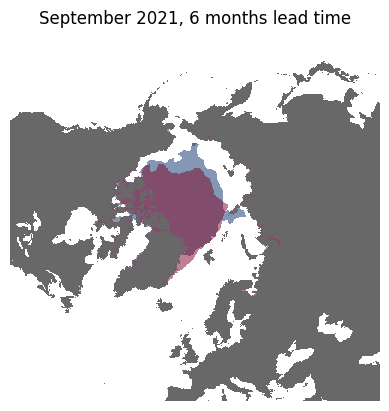

In [17]:
plot_func(pd.to_datetime('2021-09-01'), 6, download=True)

## Old

In [ ]:
experiments

{'ensemble_lstm_classification_in_0_15_out_0_5_instance_3': <__main__.Result at 0x78e3ae3e6bf0>}

In [ ]:
experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual

array([[[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0.

In [ ]:
experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat.shape

(23, 432, 432, 6)

In [ ]:
len(test_dates[12:-5]) # all the dates here are the date for the first month being predicted

23

In [ ]:
len(test_dates)

40

In [ ]:
test_dates[:-12][-1]

Timestamp('2021-12-01 00:00:00', freq='MS')

In [ ]:
test_dates[12:][24]

Timestamp('2022-09-01 00:00:00', freq='MS')

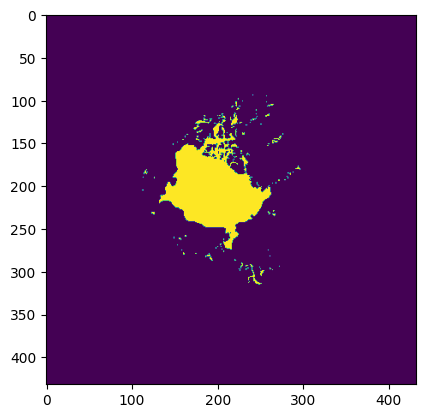

In [ ]:
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[-11,:,:,0])

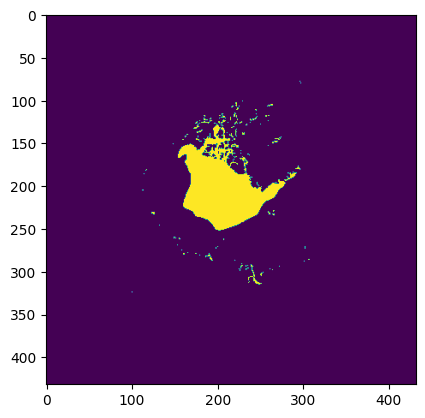

In [ ]:
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[0,:,:,0]);

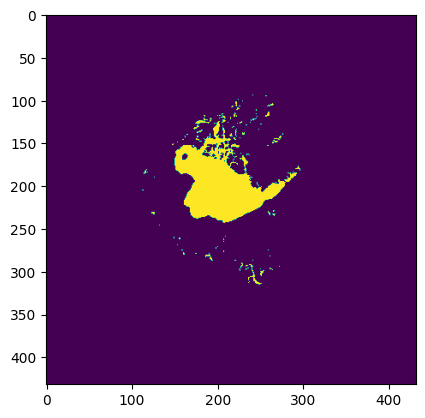

In [ ]:
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[0,:,:,0]);

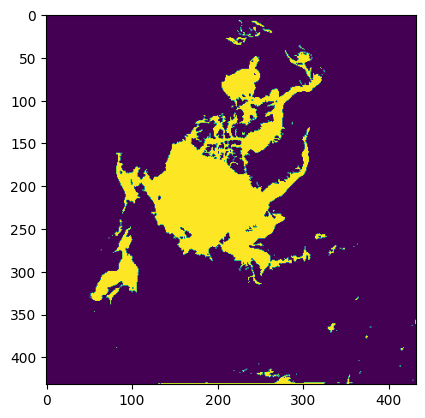

In [ ]:
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[0,:,:,5]);

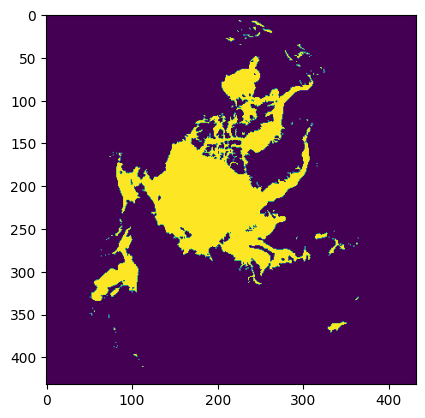

In [ ]:
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[0,:,:,5]);

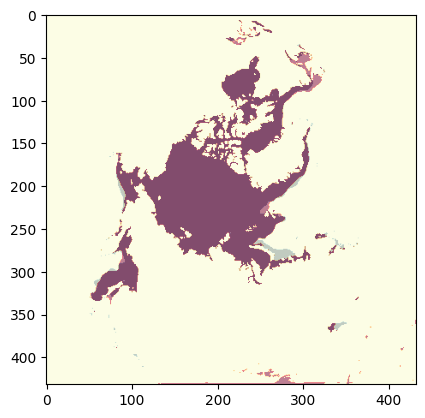

In [ ]:
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[0,:,:,5], alpha=0.5, cmap='Blues')
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[0,:,:,5], alpha=0.5, cmap='YlOrRd');

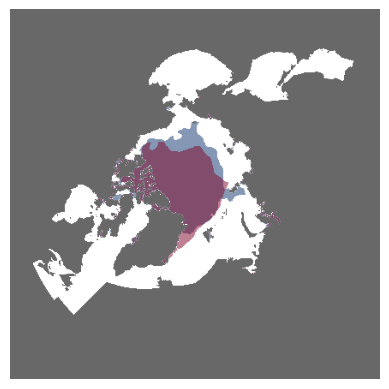

In [ ]:
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[-16,:,:,5].transpose()/2, norm=Normalize(0, 1), cmap='Blues')
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[-16,:,:,5].transpose()/2, norm=Normalize(0, 1), cmap='YlOrRd')
plt.imshow(np.ones((432, 432)), alpha=(1-seas_mask)[:,:,0].transpose(), norm=Normalize(0, 3/2), cmap='Greys')
plt.axis('off');
#plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
#plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[-16,:,:,5], alpha=0.5, cmap='YlOrRd')
#plt.imshow(1-seas_mask, alpha=0.5, cmap='Greys');

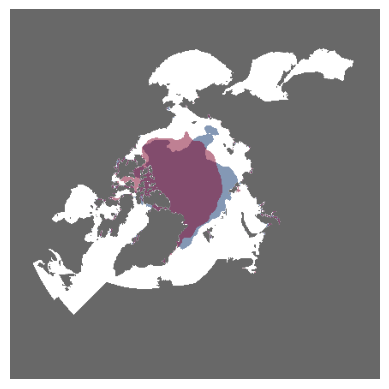

In [ ]:
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[19,:,:,5].transpose()/2, norm=Normalize(0, 1), cmap='Blues')
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[19,:,:,5].transpose()/2, norm=Normalize(0, 1), cmap='YlOrRd')
plt.imshow(np.ones((432, 432)), alpha=(1-seas_mask)[:,:,0].transpose(), norm=Normalize(0, 3/2), cmap='Greys')
plt.axis('off');
#plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
#plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[-16,:,:,5], alpha=0.5, cmap='YlOrRd')
#plt.imshow(1-seas_mask, alpha=0.5, cmap='Greys');
# this should be September 2022

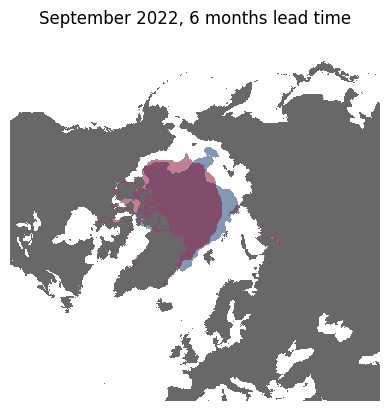

In [ ]:
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[19,:,:,5].transpose()/2, norm=Normalize(0, 1), cmap='Blues', interpolation='none')
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[19,:,:,5].transpose()/2, norm=Normalize(0, 1), cmap='YlOrRd', interpolation='none')
plt.imshow(np.ones((432, 432)), alpha=1.0*land_mask.transpose(), norm=Normalize(0, 3/2), cmap='Greys', interpolation='none')
plt.axis('off')
plt.title('September 2022, 6 months lead time');
#plt.savefig('image.png', bbox_inches='tight')#, pad_inches=0)
#plt.close(fig)
#plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[-16,:,:,5], alpha=0.5, cmap='YlOrRd')
#plt.imshow(1-seas_mask, alpha=0.5, cmap='Greys');
# this should be September 2022

In [ ]:
pd.to_datetime('2022-09-01').strftime("%B %Y")

'September 2022'

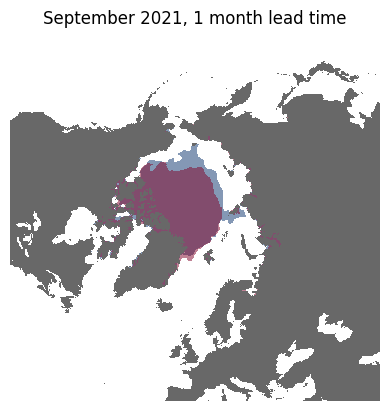

In [ ]:
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[12,:,:,0].transpose()/2, norm=Normalize(0, 1), cmap='Blues', interpolation='none')
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[12,:,:,0].transpose()/2, norm=Normalize(0, 1), cmap='YlOrRd', interpolation='none')
plt.imshow(np.ones((432, 432)), alpha=1.0*land_mask.transpose(), norm=Normalize(0, 3/2), cmap='Greys', interpolation='none')
plt.axis('off')
plt.title('September 2021, 1 month lead time');
#plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
#plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[-16,:,:,5], alpha=0.5, cmap='YlOrRd')
#plt.imshow(1-seas_mask, alpha=0.5, cmap='Greys');
# this should be September 2021

In [ ]:
test_dates

DatetimeIndex(['2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
train_dates[12:][272]

Timestamp('2012-09-01 00:00:00', freq='MS')

In [ ]:
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].train_y_actual[271,:,:,0].transpose()/2, norm=Normalize(0, 1), cmap='Blues', interpolation='none')
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].train_y_hat[271,:,:,0].transpose()/2, norm=Normalize(0, 1), cmap='YlOrRd', interpolation='none')
plt.imshow(np.ones((432, 432)), alpha=1.0*land_mask.transpose(), norm=Normalize(0, 3/2), cmap='Greys', interpolation='none')
plt.axis('off')
plt.title('September 2012, 1 month lead time');
#plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
#plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[-16,:,:,5], alpha=0.5, cmap='YlOrRd')
#plt.imshow(1-seas_mask, alpha=0.5, cmap='Greys');
# this should be September 2021

TypeError: 'NoneType' object is not subscriptable

In [ ]:
experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].train_y_hat

In [ ]:
# maybe put multiple figures together with 1 legend

In [ ]:
val_dates

DatetimeIndex(['2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
# to do: add legend and maybe title

In [ ]:
test_dates[12:][19+5]

Timestamp('2022-09-01 00:00:00', freq='MS')

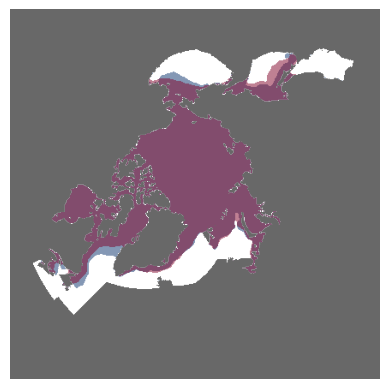

In [ ]:
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[13,:,:,5].transpose()/2, norm=Normalize(0, 1), cmap='Blues')
plt.imshow(np.ones((432, 432)), alpha=experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[13,:,:,5].transpose()/2, norm=Normalize(0, 1), cmap='YlOrRd')
plt.imshow(np.ones((432, 432)), alpha=(1-seas_mask)[:,:,0].transpose(), norm=Normalize(0, 3/2), cmap='Greys')
plt.axis('off');
#plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
#plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[-16,:,:,5], alpha=0.5, cmap='YlOrRd')
#plt.imshow(1-seas_mask, alpha=0.5, cmap='Greys');
# this should be March 2022

In [ ]:
test_dates[12:][13+5]

Timestamp('2022-03-01 00:00:00', freq='MS')

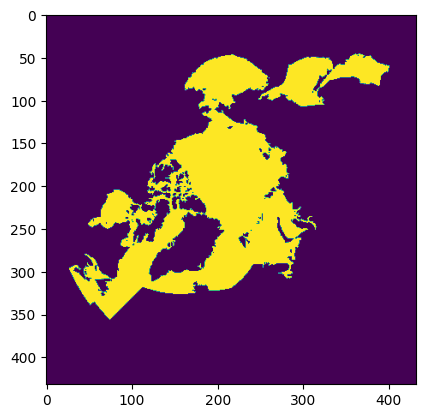

In [ ]:
plt.imshow(seas_mask[:,:,0].transpose());

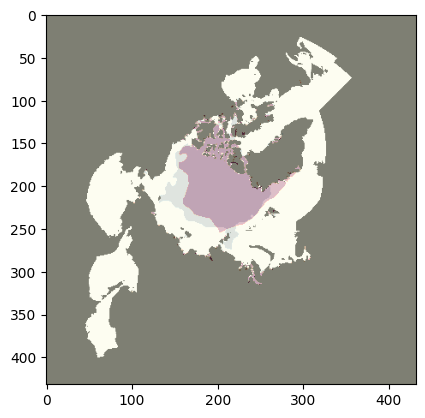

In [ ]:
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[-16,:,:,5], alpha=0.5, cmap='Blues')
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[-16,:,:,5], alpha=0.5, cmap='YlOrRd')
plt.imshow(1-seas_mask, alpha=0.5, cmap='Greys');

In [ ]:
np.ones((432, 432))

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [ ]:
# to do: find dates, also include land
# also make the color scheme match the image in the paper
# also do it for the right model(s)

In [ ]:
test_dates[36]

Timestamp('2022-09-01 00:00:00', freq='MS')

In [ ]:
test_dates

DatetimeIndex(['2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
len(test_dates)

40

In [ ]:
experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].val_y_actual.shape

(24, 432, 432, 6)

In [ ]:
len(val_dates)

41

In [ ]:
experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual.shape

(23, 432, 432, 6)

In [ ]:
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[30,:,:,5], alpha=0.5, cmap='Blues')
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[30,:,:,5], alpha=0.5, cmap='Reds');

IndexError: index 30 is out of bounds for axis 0 with size 23

In [ ]:
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[35,:,:,0], alpha=0.5, cmap='Blues')
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[35,:,:,0], alpha=0.5, cmap='Reds');

IndexError: index 35 is out of bounds for axis 0 with size 23

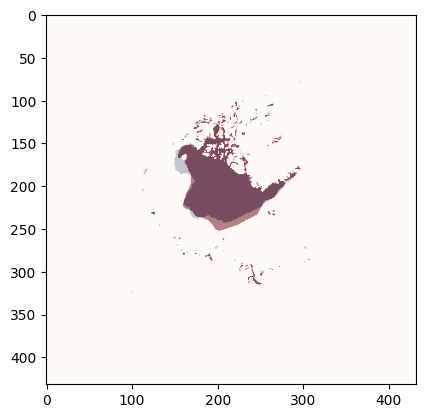

In [ ]:
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_actual[0,:,:,0], alpha=0.5, cmap='Blues')
plt.imshow(experiments['ensemble_lstm_classification_in_0_15_out_0_5_instance_3'].test_y_hat[0,:,:,0], alpha=0.5, cmap='Reds');

In [ ]:
metrics_df

,exp,predict_month,lead_month,mse,rmse,mae,r2,bin_acc,log_loss,auc,confusion
0,ensemble_lstm_classification_in_0_15_out_0_5_i...,0,0,0.044166,0.210157,0.044166,0.822829,0.955834,0.704109,0.955764,"[[0.9570679060254385, 0.04293209397456149], [0..."
1,ensemble_lstm_classification_in_0_15_out_0_5_i...,0,1,0.034228,0.185008,0.034228,0.862677,0.965772,0.545675,0.965639,"[[0.968072112459012, 0.03192788754098791], [0...."
2,ensemble_lstm_classification_in_0_15_out_0_5_i...,0,2,0.043488,0.208538,0.043488,0.825520,0.956512,0.693307,0.956181,"[[0.9621992826332917, 0.03780071736670832], [0..."
3,ensemble_lstm_classification_in_0_15_out_0_5_i...,0,3,0.045745,0.213881,0.045745,0.816481,0.954255,0.729285,0.954128,"[[0.9564749863669513, 0.0435250136330487], [0...."
4,ensemble_lstm_classification_in_0_15_out_0_5_i...,0,4,0.046610,0.215893,0.046610,0.813028,0.953390,0.743069,0.953543,"[[0.9506860903697503, 0.04931390963024978], [0..."
...,...,...,...,...,...,...,...,...,...,...,...
86,ensemble_lstm_classification_in_0_15_out_0_5_i...,12,2,0.027261,0.165110,0.027261,0.887336,0.972739,0.434612,0.970418,"[[0.957469790049281, 0.04253020995071896], [0...."
87,ensemble_lstm_classification_in_0_15_out_0_5_i...,12,3,0.036321,0.190580,0.036321,0.845292,0.963679,0.579041,0.960653,"[[0.9483925549915397, 0.051607445008460234], [..."
88,ensemble_lstm_classification_in_0_15_out_0_5_i...,12,4,0.048109,0.219338,0.048109,0.792816,0.951891,0.766975,0.947659,"[[0.931796712639335, 0.06820328736066503], [0...."
89,ensemble_lstm_classification_in_0_15_out_0_5_i...,12,5,0.048968,0.221287,0.048968,0.794417,0.951032,0.780667,0.950415,"[[0.947575221238938, 0.05242477876106195], [0...."


## Get metrics

In [ ]:
metrics_df = load_metrics_df(snapshot)
metrics_df.to_csv(f"{RESULTS_PATH}/CSVs/{snapshot}.csv")

KeyboardInterrupt: 

In [ ]:
# Load all experiment results

for snapshot in [f"{v}_20230904_ensemble" for v in ['conc', 'short', 'chen', 'anderson', 'full']]:
  metrics_df = load_metrics_df(snapshot)
  with GoogleDriveContextManager():
    metrics_df.to_csv(f"{RESULTS_PATH}/CSVs/{snapshot}.csv")

Loaded 1 experiments from drive/MyDrive/Andrew Arctic ice research/Results/conc_20230904_ensemble
Loaded 1 experiments from drive/MyDrive/Andrew Arctic ice research/Results/short_20230904_ensemble
Loaded 1 experiments from drive/MyDrive/Andrew Arctic ice research/Results/chen_20230904_ensemble
Loaded 1 experiments from drive/MyDrive/Andrew Arctic ice research/Results/anderson_20230904_ensemble
Loaded 1 experiments from drive/MyDrive/Andrew Arctic ice research/Results/full_20230904_ensemble


# Combine CSVs

In [ ]:
# Simple concat into one csv

snapshots = [f"{v}_20230904_ensemble" for v in ['conc', 'short', 'chen', 'anderson', 'full']]

with GoogleDriveContextManager():
    csv_list = []
    for snapshot in snapshots:
      csv = pd.read_csv(f"{RESULTS_PATH}/CSVs/{snapshot}.csv").drop(columns="Unnamed: 0")
      tokens = snapshot.split('_')
      csv["variables"] = tokens[0]
      csv_list.append(csv)

    combined_df = pd.concat(csv_list, axis=0)
    new_index_columns = ["exp", "variables", "predict_month", "lead_month"]
    reordered_columns = new_index_columns + [c for c in combined_df.columns if c not in new_index_columns]
    combined_df = combined_df[reordered_columns].sort_values(by=new_index_columns)

    # Uncomment to save
    combined_df.to_csv(f"{RESULTS_PATH}/CSVs/combined_variables_20230904.csv")

In [ ]:
# Take average across different runs and combine all into one csv

def to_average(df_list: List[pd.DataFrame], avg_func=np.mean):
  index_columns = ["exp", "predict_month", "lead_month"]
  df_list = [df.sort_values(by=index_columns).reset_index(drop=True) for df in df_list]
  indices = df_list[0][index_columns]
  columns = df_list[0].columns

  for df in df_list:
    assert df[["exp", "predict_month", "lead_month"]].equals(indices), f'{df[["exp", "predict_month", "lead_month"]]} does not match with {indices}'
    assert df.columns.equals(columns), f"{df.columns} does not match with {columns}"

  avg_columns = ["mse", "rmse", "mae", "r2", "bin_acc", "log_loss", "auc"]
  avg_metrics = avg_func(np.stack([df[avg_columns] for df in df_list], axis=2), axis=2)

  # confusion matrix in csv is a string of format [[a b]\n[c d]].
  # It has shape (1, 4), once parsed by fromstring.
  fromstring = lambda x: np.fromstring(x.replace("[", "").replace("]", "").replace("nan", "0").replace(",", " "), sep=" ")
  confusion_values_list = [np.stack(df["confusion"].apply(fromstring).values, axis=0) for df in df_list]
  avg_confusion = avg_func(np.stack(confusion_values_list, axis=2), axis=2)
  avg_df = df_list[0].copy()
  avg_df[avg_columns] = avg_metrics
  avg_df["confusion"] = list(avg_confusion)
  return avg_df

# snapshots = [f"{t}_20230904" for t in ("short", "chen", "anderson", "full", "conc_arch")]
snapshots = [f"{t}_20230904" for t in ("conc_24m",)]

with GoogleDriveContextManager():
  for avg_name, avg_func in [("mean", np.mean), ("median", np.median)]:
    avg_csv_list = []
    for snapshot in snapshots:
      csv_list = []
      for r in ["", "_1", "_2"]:
        csv = pd.read_csv(f"{RESULTS_PATH}/CSVs/{snapshot}{r}.csv").drop(columns="Unnamed: 0")
        csv_list.append(csv)
      avg_csv = to_average(csv_list, avg_func=avg_func)
      avg_csv["variables"] = f"{snapshot.split('_')[0]}"
      avg_csv_list.append(avg_csv)

    combined_df = pd.concat(avg_csv_list, axis=0)
    new_index_columns = ["exp", "variables", "predict_month", "lead_month"]
    reordered_columns = new_index_columns + [c for c in combined_df.columns if c not in new_index_columns]
    combined_df = combined_df[reordered_columns].sort_values(by=new_index_columns)

    # Uncomment to save
    combined_df.to_csv(f"{RESULTS_PATH}/CSVs/combined_24m_{avg_name}_20230904.csv")

Mounted at /content/drive


In [ ]:
with GoogleDriveContextManager():
  df = pd.read_csv(f"{RESULTS_PATH}/CSVs/conc_20230904.csv")

Mounted at /content/drive


In [ ]:
combined_df

,exp,variables,predict_month,lead_month,mse,rmse,mae,r2,bin_acc,log_loss,auc,confusion
0,lstm_classification_in_0_15_out_0_5,short,0,0,0.049340,0.222121,0.049340,0.802187,0.950660,0.786599,0.950648,"[0.9508930866666668, 0.049106913333333335, 0.0..."
1,lstm_classification_in_0_15_out_0_5,short,0,1,0.035865,0.189370,0.035865,0.856230,0.964135,0.571782,0.964014,"[0.9666119466666666, 0.033388053333333334, 0.0..."
2,lstm_classification_in_0_15_out_0_5,short,0,2,0.048698,0.220667,0.048698,0.804776,0.951302,0.776369,0.951301,"[0.9513139133333333, 0.04868608666666666, 0.04..."
3,lstm_classification_in_0_15_out_0_5,short,0,3,0.051609,0.227174,0.051609,0.793088,0.948391,0.822778,0.948156,"[0.9530576700000001, 0.04694233, 0.05674576, 0..."
4,lstm_classification_in_0_15_out_0_5,short,0,4,0.052618,0.229386,0.052618,0.789038,0.947382,0.838862,0.947405,"[0.9469204566666667, 0.05307954333333333, 0.05..."
...,...,...,...,...,...,...,...,...,...,...,...,...
541,lstm_regression__lstm_classification_in_0_15_o...,conc,12,2,0.044648,0.210814,0.044648,0.815101,0.955352,0.711790,0.948328,"[0.91029707, 0.08970293, 0.013641396666666666,..."
542,lstm_regression__lstm_classification_in_0_15_o...,conc,12,3,0.052805,0.229746,0.052805,0.774787,0.947195,0.841839,0.941087,"[0.91658261, 0.08341739, 0.034408666666666664,..."
543,lstm_regression__lstm_classification_in_0_15_o...,conc,12,4,0.059777,0.244491,0.059777,0.741852,0.940223,0.952995,0.937200,"[0.9260714833333333, 0.07392851666666667, 0.05..."
544,lstm_regression__lstm_classification_in_0_15_o...,conc,12,5,0.057182,0.239041,0.057182,0.759891,0.942818,0.911625,0.936661,"[0.9083797666666666, 0.09162023333333334, 0.03..."


# Fix month

From the previous, `predict_month` is actually one month after the last observation, not the predicted month; thus, this makes it so that `predict_month` is the month being predicted instead.

In [ ]:
# clips a number between 1 and 12
def clip_month(n: int) -> int:
  return (n - 1) % 12 + 1

In [ ]:
def fix_predict_month(df: pd.DataFrame) -> pd.DataFrame:
  # remove the parts where lead_month == 0 and where predict_month == 0, to regenerate them later (or maybe not at all)
  new_df = df[(df['lead_month'] != 0) & (df['predict_month'] != 0)].copy()
  new_df['predict_month'] = clip_month(df['predict_month'] + df['lead_month'] - 1)
  return new_df

In [ ]:
csv_names = ('combined_variables_20230904.csv', 'conc_umap_20230904_ensemble.csv', 'conc_24m_20230904_ensemble.csv', 'combined_wavelet_20230904.csv', 'final_20231106_ensemble.csv')

In [ ]:
with GoogleDriveContextManager():
  for csv_name in csv_names:
    df = pd.read_csv(f"{RESULTS_PATH}/CSVs/{csv_name}")
    new_df = fix_predict_month(df)
    new_df.to_csv(f"{RESULTS_PATH}/CSVs/New/{csv_name}")

# Unused stuff (need cleaning up)

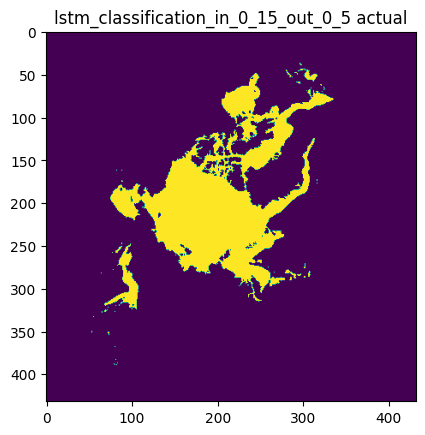

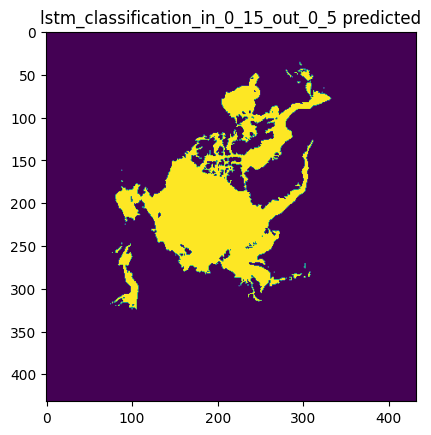

metrics = {'mse': 0.04948246, 'rmse': 0.2224465352956839, 'mae': 0.04948246, 'r2': 0.8016163964604409, 'bin_acc': 0.950517538594142, 'log_loss': 0.7888685713551739, 'auc': 0.9504131960413157, 'confusion': array([[0.95259497, 0.04740503],
       [0.05176858, 0.94823142]])}


In [ ]:
# Sample one y and y_hat
name, result = next(iter(experiments.items()))
plt.imshow(masked(result.val_y_actual)[0, :, :, 0])
plt.title(f"{name} actual")
plt.show()
plt.imshow(masked(result.val_y_hat)[0, :, :, 0])
plt.title(f"{name} predicted")
plt.show()

print(f"metrics = {metrics(result.val_y_actual, result.val_y_hat)}")

,exp,predict_month,lead_month,mse,rmse,mae,r2,bin_acc,log_loss,auc,confusion
0,lstm_classification_in_0_15_out_0_5,0,0,0.049482,0.222447,0.049482,0.801616,0.950518,0.788869,0.950413,"[[0.9525949685814822, 0.047405031418517866], [..."
1,lstm_classification_in_0_15_out_0_5,0,1,0.035368,0.188064,0.035368,0.858224,0.964632,0.563852,0.964356,"[[0.9703229261059395, 0.029677073894060466], [..."
2,lstm_classification_in_0_15_out_0_5,0,2,0.048990,0.221336,0.048990,0.803609,0.951010,0.781010,0.950861,"[[0.954052289887799, 0.04594771011220097], [0...."
3,lstm_classification_in_0_15_out_0_5,0,3,0.051777,0.227545,0.051777,0.792417,0.948223,0.825448,0.947982,"[[0.9530219283879279, 0.046978071612072146], [..."
4,lstm_classification_in_0_15_out_0_5,0,4,0.052705,0.229576,0.052705,0.788690,0.947295,0.840244,0.947304,"[[0.9471216397592874, 0.05287836024071262], [0..."
...,...,...,...,...,...,...,...,...,...,...,...
86,lstm_classification_in_0_15_out_0_5,12,2,0.031565,0.177665,0.031565,0.869281,0.968435,0.503219,0.966342,"[[0.955008835123012, 0.044991164876987906], [0..."
87,lstm_classification_in_0_15_out_0_5,12,3,0.047883,0.218822,0.047883,0.795780,0.952117,0.763368,0.949522,"[[0.9391098974094029, 0.060890102590597094], [..."
88,lstm_classification_in_0_15_out_0_5,12,4,0.056010,0.236663,0.056010,0.758123,0.943990,0.892927,0.940281,"[[0.9266208575268136, 0.07337914247318644], [0..."
89,lstm_classification_in_0_15_out_0_5,12,5,0.049813,0.223188,0.049813,0.790836,0.950187,0.794138,0.948228,"[[0.939229388988573, 0.06077061101142695], [0...."


In [ ]:
with GoogleDriveContextManager():
  metrics_df.to_csv(f"{RESULTS_PATH}/CSVs/{snapshot}.csv")

Mounted at /content/drive


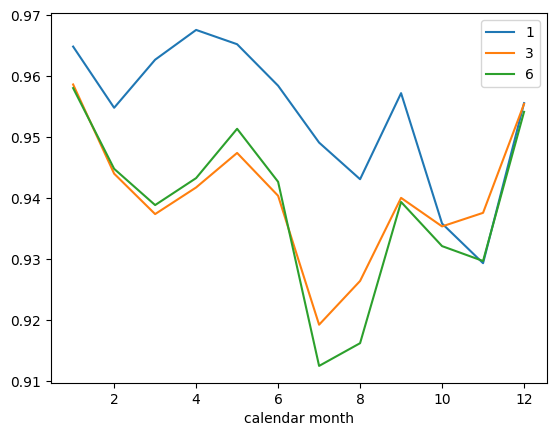

In [ ]:
df.set_index('calendar month').groupby('lead time')['binary accuracy'].plot(legend=True);

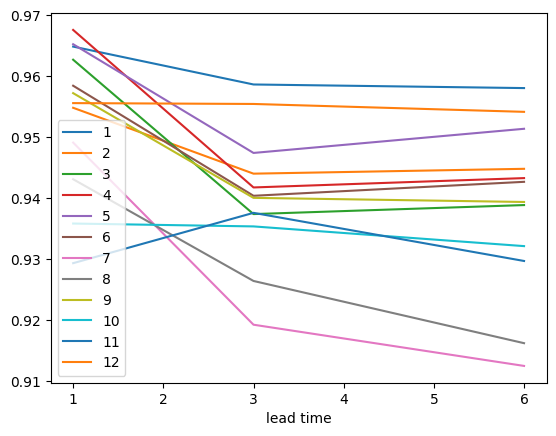

In [ ]:
df.set_index('lead time').groupby('calendar month')['binary accuracy'].plot(legend=True);

In [ ]:
df.to_csv('convlstm.csv')

In [ ]:
df.to_csv('cnn.csv')

In [ ]:
# to do: put into CSV

print('\n'.join([', '.join([str(val) for val in row]) for row in table]))

0.9648612457865817, 0.9586461652121716, 0.9580551322897908
0.9548229209955211, 0.944018100383248, 0.9448123008726971
0.9627095165535393, 0.9373874497852889, 0.9388650320912407
0.9675947730525927, 0.9417555524772591, 0.9432885441196842
0.965249111141894, 0.9474165396869373, 0.9513783072447708
0.9584429976451032, 0.9403887888442536, 0.942679041418479
0.9491157593387819, 0.9192408920903172, 0.9124809530405873
0.9431038463314402, 0.926416401163596, 0.9162118483631159
0.957223992242693, 0.9400470979360022, 0.9393729510089117
0.9358359883640394, 0.9353650090040172, 0.9321327977097474
0.929334626217851, 0.9375906173523572, 0.9296947869049268
0.9555894168167336, 0.9554508934755507, 0.9541580089578428


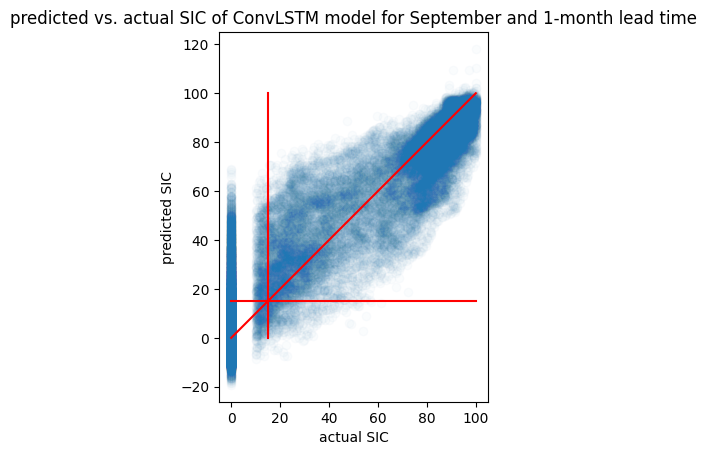

In [ ]:
# to do: maybe denormalize
month = 9
lead_time = 1
lead_time_idx = 0

fix, ax = plt.subplots()
ax.scatter(denormalize(flatten_and_mask(get_for_month(convlstm_sic_result.val_y_actual, month, lead_time, ValOrTest.VAL)[:, :, :, lead_time_idx:lead_time_idx+1], seas_mask), conc_mean, conc_std), denormalize(flatten_and_mask(get_for_month(convlstm_sic_result.val_y_hat, month, lead_time, ValOrTest.VAL)[:, :, :, lead_time_idx:lead_time_idx+1], seas_mask), conc_mean, conc_std), alpha=0.02)
ax.plot(np.linspace(0, 100), np.linspace(0, 100), 'r')
ax.plot(np.linspace(0, 100), 15*np.ones(50), 'r')
ax.plot(15*np.ones(50), np.linspace(0, 100), 'r')
plt.title('predicted vs. actual SIC of ConvLSTM model for September and 1-month lead time')
plt.ylabel('predicted SIC')
plt.xlabel('actual SIC')
ax.set_aspect('equal')
plt.show()

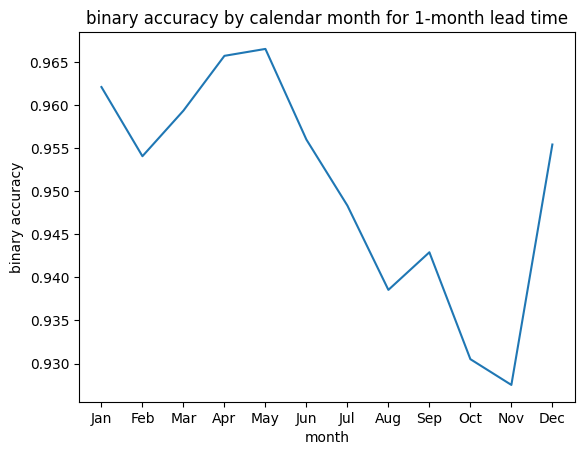

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

bin_accs = [convlstm_result.calculate_metrics(ValOrTest.VAL, month=month, lead_time=1, lead_time_idx=0)['bin_acc'] for month in range(1, 12+1)]

plt.plot(months, bin_accs)
plt.title('binary accuracy by calendar month for 1-month lead time')
plt.ylabel('binary accuracy')
plt.xlabel('month')

plt.show()

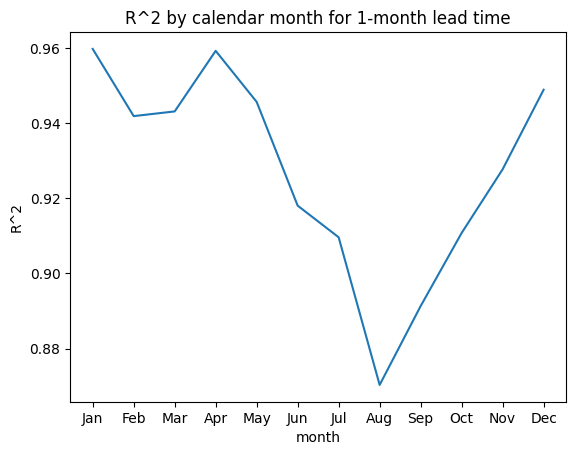

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

r_squared = [convlstm_result.calculate_metrics(ValOrTest.VAL, month=month, lead_time=1, lead_time_idx=0)['r2'] for month in range(1, 12+1)]

plt.plot(months, r_squared)
plt.title('R^2 by calendar month for 1-month lead time')
plt.ylabel('R^2')
plt.xlabel('month')

plt.show()

In [ ]:
lstm_result2.show_metrics(ValOrTest.VAL, lead_time=1, lead_time_idx=0)

Mean squared error: 0.2763446271419525
Root mean squared error: 0.5256849124161284
Mean absolute error: 0.33932557702064514
R^2 score: 0.9034367078637178
Binary accuracy: 0.9214857397915993


In [ ]:
lstm_result2.show_metrics(ValOrTest.VAL)

Mean squared error: 0.3096214532852173
Root mean squared error: 0.55643638745612
Mean absolute error: 0.3553514778614044
R^2 score: 0.8919986157748231
Binary accuracy: 0.9278108694648382


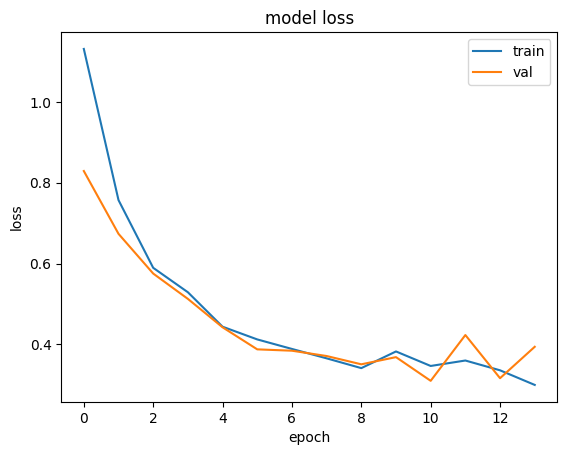

In [ ]:
lstm_result2.show_history()

In [ ]:
lstm_result2.show_metrics(ValOrTest.VAL)

Mean squared error: 0.3096214532852173
Root mean squared error: 0.55643638745612
Mean absolute error: 0.3553514778614044
R^2 score: 0.8919986157748231
Binary accuracy: 0.9278108694648382


In [ ]:
cnn_result.show_metrics(ValOrTest.VAL)

Mean squared error: 0.2757370173931122
Root mean squared error: 0.5251066723943928
Mean absolute error: 0.32212045788764954
R^2 score: 0.9038180621260613
Binary accuracy: 0.9285586389825204


In [ ]:
lstm_result2.show_metrics(ValOrTest.VAL, lead_time=0)

Mean squared error: 0.2763446271419525
Root mean squared error: 0.5256849124161284
Mean absolute error: 0.33932557702064514
R^2 score: 0.9034367078637178
Binary accuracy: 0.9214857397915993


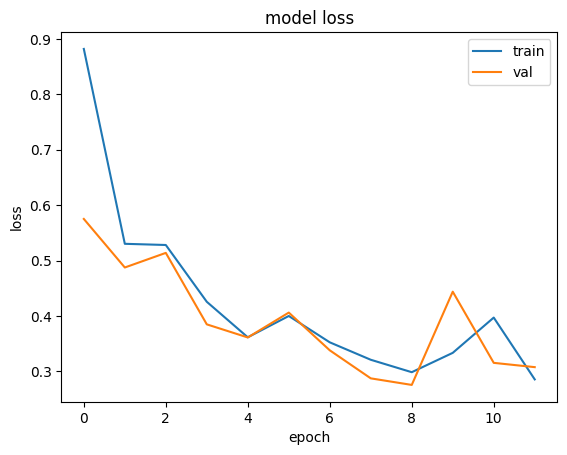

In [ ]:
show_history(cnn_result.history)

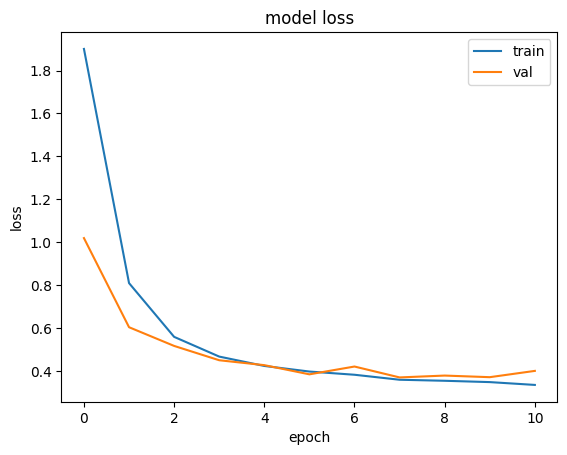

In [ ]:
show_history(lstm_result.history)

In [ ]:
show_metrics(results_of)

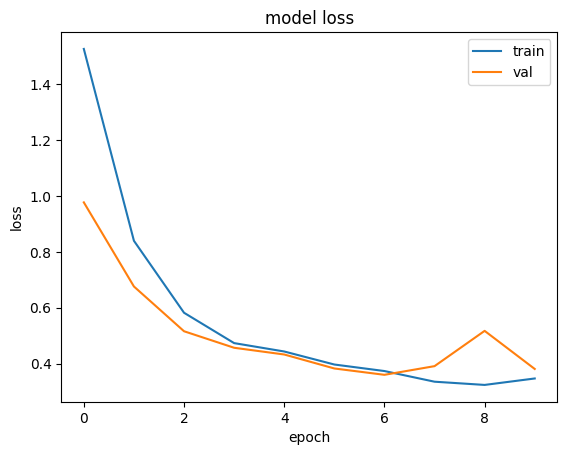

In [ ]:
show_history(history.history) # LSTM

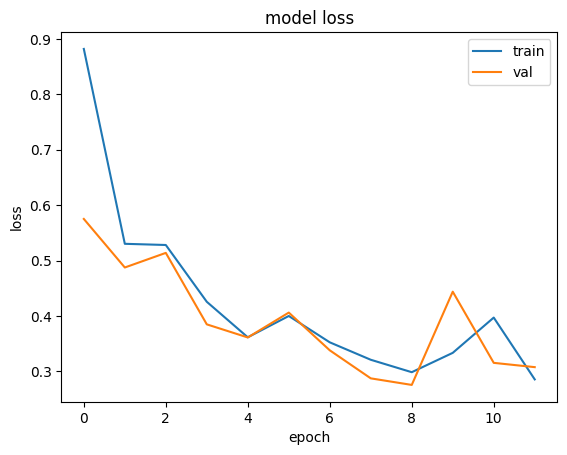

In [ ]:
show_history(history.history) # most recent, no LSTM

## Get results by month (to do)

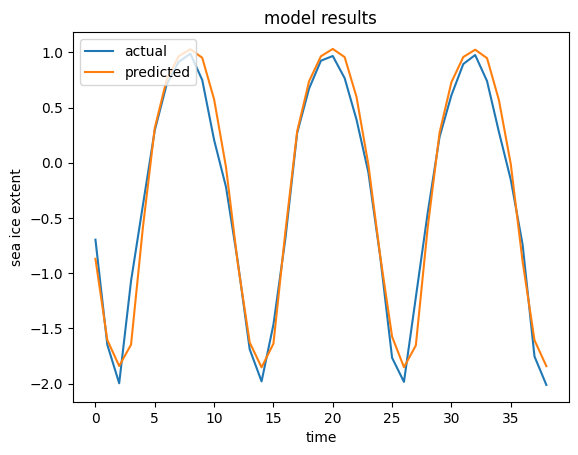

In [ ]:
import matplotlib.pyplot as plt

plt.plot(val_y_actual)
plt.plot(val_y_hat)
plt.title('model results')
plt.ylabel('sea ice extent')
plt.xlabel('time')
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

In [ ]:
get_for_month(np.zeros((53, 20, 2)), 2, 1, ValOrTest.VAL).shape

(4, 20, 2)

In [ ]:
y_array

In [ ]:
avg_val_y_actuals[1]

[0.9771507144146883,
 0.7521545219565445,
 0.29250818482445223,
 -0.15275573370042078,
 -0.830633929425161,
 -1.737120340545931,
 -1.9940008445739608,
 -1.2515987845497092,
 -0.5100176388295224,
 0.2661075808057208,
 0.6638241428391471,
 0.9103611266359574]

In [ ]:
avg_val_y_actuals[0]

[0.6638241428391471,
 0.9103611266359574,
 0.9771507144146883,
 0.7521545219565445,
 0.29250818482445223,
 -0.15275573370042078,
 -0.7972062989636329,
 -1.7149228177640128,
 -1.9940008445739608,
 -1.2515987845497092,
 -0.5100176388295224,
 0.2661075808057208]

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

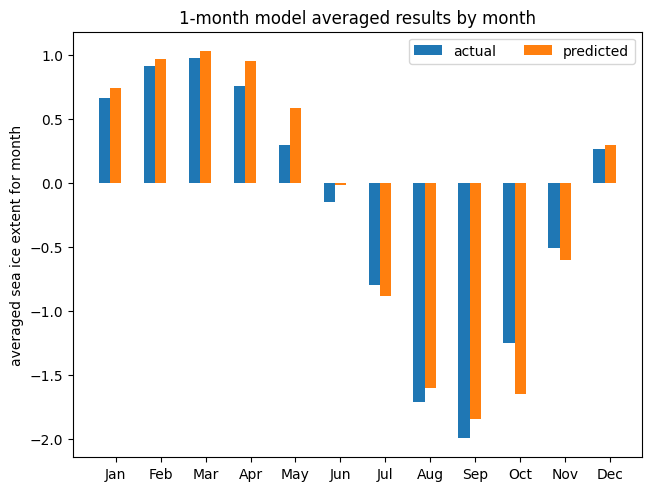

In [ ]:
# mostly copied from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

import matplotlib.pyplot as plt
import numpy as np

penguin_means = {
    'actual': avg_val_y_actuals[0],
    'predicted': avg_val_y_hats[0],
}

x = np.arange(len(months))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('averaged sea ice extent for month')
ax.set_title('1-month model averaged results by month')
ax.set_xticks(x + width, months)
ax.legend(loc='upper right', ncols=3)
#ax.set_ylim(0, 250)

plt.show()

In [ ]:
# mostly copied from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
import matplotlib.pyplot as plt
import numpy as np

def stuff(grid_idx):
  penguin_means = {
      'actual': avg_val_y_actuals[grid_idx],
      'predicted': avg_val_y_hats[grid_idx],
  }

  x = np.arange(len(months))  # the label locations
  width = 0.25  # the width of the bars
  multiplier = 0

  fig, ax = plt.subplots(layout='constrained')

  for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('sea ice extent')
  ax.set_title(f'{(1, 3, 6)[grid_idx]}-month lead time model results by month')
  ax.set_xticks(x + width, months)
  ax.legend(loc='upper right', ncols=3)
  #ax.set_ylim(0, 250)

  plt.show()